In [1]:
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Standar imports
import numpy as np
import pandas as pd


from sklearn import metrics

# To acquire the data from SQL
import env

### Question: Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
# Adding new values for testing anol=maly detection
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)
df.head()

/var/folders/t2/c4rfp_5j33nfsbfkcj7scwjh0000gn/T/ipykernel_2264/329982034.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [7]:
# Size of the request in megabytes
df['size_mb'] = df['size'] / 1024 / 1024

# Setting the timestamp column to a datetime format and then to the index
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [8]:
# Checking the new columns
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [12]:
# the number of times an ip address shows up
df.ip.value_counts(), df.ip.value_counts(normalize=True)

(97.105.19.58      11999
 173.173.113.51     1059
 72.181.113.170      613
 72.181.105.81       246
 68.201.219.223       21
 24.26.242.9          21
 35.175.171.137        2
 52.87.230.102         2
 70.121.214.34         2
 52.90.165.200         1
 95.31.16.121          1
 95.31.18.119          1
 45.23.250.16          1
 52.91.30.150          1
 34.207.64.242         1
 3.88.129.158          1
 54.172.14.223         1
 3.92.201.136          1
 35.174.209.2          1
 54.145.52.184         1
 34.229.70.250         1
 97.105.15.120         1
 Name: ip, dtype: int64,
 97.105.19.58      0.858420
 173.173.113.51    0.075762
 72.181.113.170    0.043855
 72.181.105.81     0.017599
 68.201.219.223    0.001502
 24.26.242.9       0.001502
 35.175.171.137    0.000143
 52.87.230.102     0.000143
 70.121.214.34     0.000143
 52.90.165.200     0.000072
 95.31.16.121      0.000072
 95.31.18.119      0.000072
 45.23.250.16      0.000072
 52.91.30.150      0.000072
 34.207.64.242     0.000072
 3.88

In [14]:
# number of individual ip addresses
len(df.ip.value_counts())

22

def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [24]:
# Creating a separate Dataframe showing the counts of each time an IP address was used
ip = pd.DataFrame(df.ip.value_counts())
ip.head()

,ip
97.105.19.58,11999
173.173.113.51,1059
72.181.113.170,613
72.181.105.81,246
68.201.219.223,21


In [27]:
df.ip.value_counts(normalize=True).values

array([8.58420375e-01, 7.57619116e-02, 4.38546287e-02, 1.75990843e-02,
       1.50236085e-03, 1.50236085e-03, 1.43081986e-04, 1.43081986e-04,
       1.43081986e-04, 7.15409930e-05, 7.15409930e-05, 7.15409930e-05,
       7.15409930e-05, 7.15409930e-05, 7.15409930e-05, 7.15409930e-05,
       7.15409930e-05, 7.15409930e-05, 7.15409930e-05, 7.15409930e-05,
       7.15409930e-05, 7.15409930e-05])

In [28]:
# Adding columns showing the normality of each IP address
ip['prob'] = df.ip.value_counts(normalize=True).values
ip

,ip,prob
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502
24.26.242.9,21,0.001502
35.175.171.137,2,0.000143
52.87.230.102,2,0.000143
70.121.214.34,2,0.000143
52.90.165.200,1,0.000072


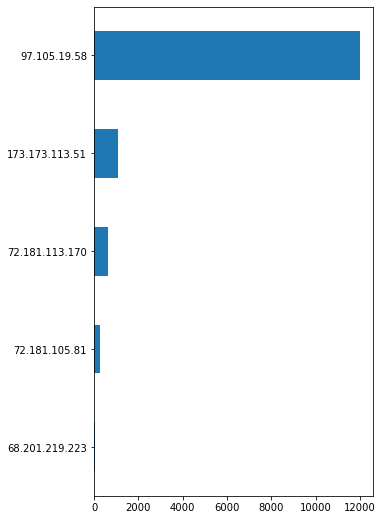

In [57]:
# Visualizing top users
ip['ip'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

In [35]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [37]:
df.ip

timestamp
2019-04-16 19:34:42     97.105.19.58
2019-04-16 19:34:42     97.105.19.58
2019-04-16 19:34:44     97.105.19.58
2019-04-16 19:34:46     97.105.19.58
2019-04-16 19:34:48     97.105.19.58
                           ...      
2019-04-17 12:55:14     97.105.19.58
2019-04-21 10:02:41     95.31.18.119
2019-04-17 19:36:41     95.31.16.121
2019-04-18 19:42:41    97.105.15.120
2019-04-19 19:42:41     97.105.19.58
Name: ip, Length: 13978, dtype: object

In [50]:
# 
print(f'Year count: {df.index.year.value_counts()}')
print('------')
print(f'Month count: {df.index.month.value_counts()}')
print('------')
print(f'Day count: {df.index.day.value_counts()}')
print('------')
print(f'Hour count: {df.index.hour.value_counts()}')

Year count: 2019    13978
Name: timestamp, dtype: int64
------
Month count: 4    13978
Name: timestamp, dtype: int64
------
Day count: 16    11947
17     2028
21        1
18        1
19        1
Name: timestamp, dtype: int64
------
Hour count: 20    4587
21    3430
19    2247
22    1684
3      807
1      380
2      284
5      253
4      209
12      70
6       15
0        8
23       2
10       2
Name: timestamp, dtype: int64


In [58]:
#sns.scatterplot(df, x=df.index, y=df.ip)

In [59]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [72]:
print(len(df.groupby('ip').status_code.value_counts(normalize=True)))
df.groupby('ip').status_code.value_counts(normalize=True)#.reset_index()

24


ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
95.31.16.121    301            1.000000
95.31.18.119    200            1.000000
97.105.15.120   301            1.000000
97.105.19.58    200            0.998833
                499            0.001167
Name: status

In [74]:
len(ip)

22

In [83]:
# new column has to be rename to avoid two columns with the same name
status = pd.DataFrame(df.groupby('ip').status_code.value_counts(normalize=True).rename('prob_of_code'))
status

,,prob_of_code
ip,status_code,
173.173.113.51,200,1.000000
24.26.242.9,200,1.000000
3.88.129.158,200,1.000000
3.92.201.136,200,1.000000
34.207.64.242,200,1.000000
34.229.70.250,200,1.000000
35.174.209.2,200,1.000000
35.175.171.137,200,1.000000
45.23.250.16,200,1.000000


In [85]:
# Reset the index
status = status.reset_index()
status.head()

,ip,status_code,prob_of_code
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [ ]:
Conditional Probabilities
HTTP Status Codes

200: ok
3xx: redirects
4xx: client level errors -- the requester did something wrong
5xx: server level errors -- the server did something wrong
What is probability of a certain status code given an IP address?

In [127]:
# 
df.groupby('ip').size() / len(df)

ip
173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001502
70.121.214.34     0.000143
72.181.105.81     0.017599
72.181.113.170    0.043855
95.31.16.121      0.000072
95.31.18.119      0.000072
97.105.15.120     0.000072
97.105.19.58      0.858420
dtype: float64

In [129]:
status [status.prob_of_code < 1]

,ip,status_code,prob_of_code
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [133]:
df[df.ip == '72.181.113.170'].sort_values('status_code', ascending=False)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:48:36,72.181.113.170,GET,/api/v1/sales?page=8,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:44,72.181.113.170,GET,/api/v1/sales?page=133,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:17,72.181.113.170,GET,/api/v1/sales?page=120,HTTP/1.1,200,510681,python-requests/2.21.0,0.487023
2019-04-17 03:42:01,72.181.113.170,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.487417
2019-04-17 03:42:03,72.181.113.170,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.487605
...,...,...,...,...,...,...,...,...
2019-04-17 03:28:07,72.181.113.170,GET,/api/v1/sales?page=100,HTTP/1.1,200,512674,python-requests/2.21.0,0.488924
2019-04-17 03:28:08,72.181.113.170,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.486859
2019-04-17 03:28:11,72.181.113.170,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.488865


In [134]:
fd = df.merge(status, how='left', on=['ip','status_code'])
fd.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,prob_of_code
0,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,0.998833
1,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,0.998833
2,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,0.998833
3,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,0.998833
4,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,0.998833
